# Chapter 5: Evaluating Predictive Performance

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.


## Import required packages

In [3]:
!pip install dmba

In [3]:
import sys
!{sys.executable} -m pip install dmba  #Kernel Restart

  Using cached dmba-0.2.4-py3-none-any.whl.metadata (1.9 kB)
Using cached dmba-0.2.4-py3-none-any.whl (11.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 7.3 MB/s eta 0:00:0000:01
  Attempting uninstall: joblib
    Found existing installation: joblib 0.11
    Uninstalling joblib-0.11:
      Successfully uninstalled joblib-0.11


In [2]:
%matplotlib inline

import math
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
# import matplotlib.pyplot as plt 만 했을때 no display .. agg로 설정되는 경우 아래 실행
#import matplotlib
#matplotlib.use('module://matplotlib_inline.backend_inline')

import matplotlib.pyplot as plt

from dmba import regressionSummary, classificationSummary, liftChart, gainsChart

## Table 5.1
파일을 불러오고 학습용 데이터와 검증용 데이터 세트를 생성하라.

In [3]:
# Load data frame and select columns for regression analysis
car_df = pd.read_csv('../data/ToyotaCorolla.csv')

# create a list of predictor variables by remvoing output variables and text columns
excludeColumns = ('Price', 'Id', 'Model', 'Fuel_Type', 'Color')
predictors = [s for s in car_df.columns if s not in excludeColumns]
outcome = 'Price'

# partition data
X = car_df[predictors]
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# train linear regression model
reg = LinearRegression()
reg.fit(train_X, train_y)

# evaluate performance
# training
regressionSummary(train_y, reg.predict(train_X))
# validation
regressionSummary(valid_y, reg.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1121.0606
            Mean Absolute Error (MAE) : 811.6770
          Mean Percentage Error (MPE) : -0.8630
Mean Absolute Percentage Error (MAPE) : 8.0054

Regression statistics

                      Mean Error (ME) : 97.1891
       Root Mean Squared Error (RMSE) : 1382.0352
            Mean Absolute Error (MAE) : 880.1396
          Mean Percentage Error (MPE) : 0.0138
Mean Absolute Percentage Error (MAPE) : 8.8744


## Figure 5.1

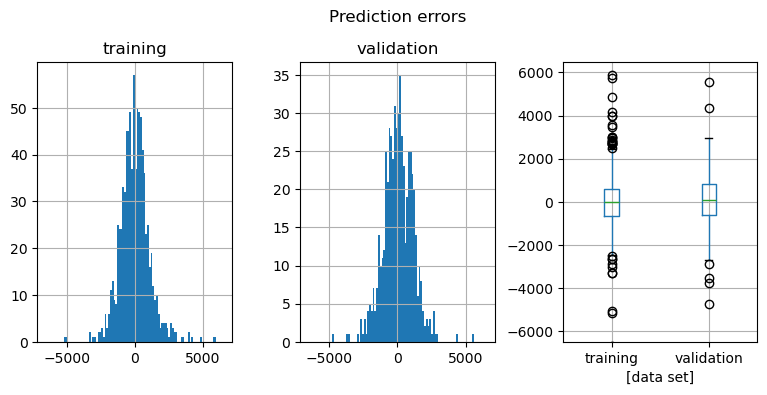

In [4]:
pred_error_train = pd.DataFrame({
    'residual': train_y - reg.predict(train_X), 
    'data set': 'training'
})
pred_error_valid = pd.DataFrame({
    'residual': valid_y - reg.predict(valid_X), 
    'data set': 'validation'
})

boxdata_df = pd.concat([pred_error_train, pred_error_valid], ignore_index=True)

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(9, 4)
common = {'bins': 100, 'range': [-6500, 6500]}
pred_error_train.hist(ax=axes[0], **common)
pred_error_valid.hist(ax=axes[1], **common)
boxdata_df.boxplot(ax=axes[2], by='data set')

axes[0].set_title('training')
axes[1].set_title('validation')
axes[2].set_title(' ')
axes[2].set_ylim(-6500, 6500)
plt.suptitle('Prediction errors') 
plt.subplots_adjust(bottom=0.15, top=0.85, wspace=0.35)

plt.show()

## Figure 5.2

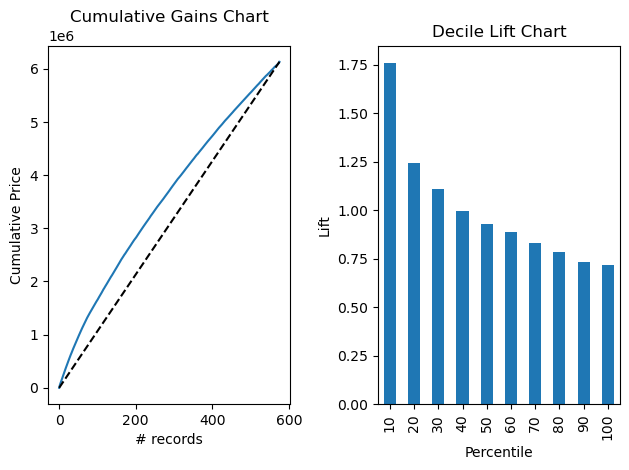

Lift based on meanResponse 1.7618191980414206
Expected cumulative price for 10% random sales 613291.8
Cumulative price for top 10% sales 1089905
Lift calculated based on gains chart 1.777139364980911


In [5]:
# sort the actual values in descending order of the prediction
df = pd.DataFrame({
    'predicted': reg.predict(valid_X),
    'actual': valid_y, 
})
df = df.sort_values(by=['predicted'], ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(df['actual'], ax=axes[0])
ax.set_ylabel('Cumulative Price')
ax.set_title('Cumulative Gains Chart')

ax = liftChart(df['actual'], ax=axes[1], labelBars=False)
ax.set_ylabel('Lift')

plt.tight_layout()
plt.show()


# group the sorted predictions into 10 roughly equal groups and calculate the mean
sorted_act_v = df['actual']
groups = [int(10 * i / len(sorted_act_v)) for i in range(len(sorted_act_v))]
meanPercentile = sorted_act_v.groupby(groups).mean()
meanResponse = meanPercentile / sorted_act_v.mean()
meanResponse.index = (meanResponse.index + 1) * 10
print('Lift based on meanResponse', meanResponse[10])
random10 = sorted_act_v.cumsum().iloc[-1] / 10  # expected cumulative price without lift for 10% sales
cumPred10 = sorted_act_v.cumsum().iloc[57]  # cumulative price based on model for top 10%
print('Expected cumulative price for 10% random sales', random10)
print('Cumulative price for top 10% sales', cumPred10)
print('Lift calculated based on gains chart', cumPred10 / random10)

## Table 5.5

In [6]:
owner_df = pd.read_csv('../data/ownerExample.csv')
owner_df.head()
class_names = ['nonowner', 'owner']

In [7]:
predicted = ['owner' if p > 0.5 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.8750)

         Prediction
  Actual nonowner    owner
nonowner       10        2
   owner        1       11


In [8]:
predicted = ['owner' if p > 0.25 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.7917)

         Prediction
  Actual nonowner    owner
nonowner        8        4
   owner        1       11


In [9]:
predicted = ['owner' if p > 0.75 else 'nonowner' for p in owner_df.Probability]
classificationSummary(owner_df.Class, predicted, class_names=class_names)

Confusion Matrix (Accuracy 0.7500)

         Prediction
  Actual nonowner    owner
nonowner       11        1
   owner        5        7


## Figure 5.4
다양한 기준값에서 정확도를 계산하고 그래프를 작성하라.

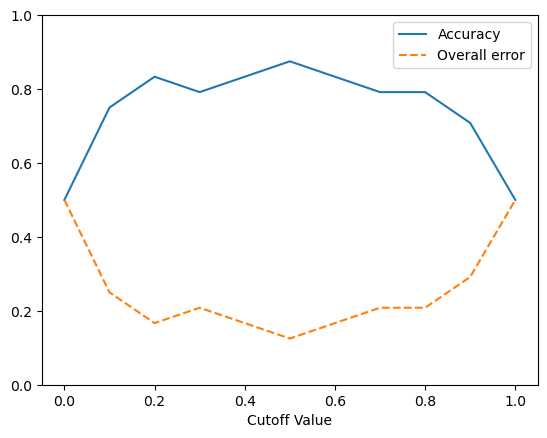

In [10]:
df = pd.read_csv('../data/liftExample.csv')

cutoffs = [i * 0.1 for i in range(0, 11)]
accT = []
for cutoff in cutoffs:
    predicted = [1 if p > cutoff else 0 for p in df.prob]
    accT.append(accuracy_score(df.actual, predicted))

line_accuracy = plt.plot(cutoffs, accT, '-', label='Accuracy')[0]
line_error = plt.plot(cutoffs, [1 - acc for acc in accT], '--', label='Overall error')[0]
plt.ylim([0,1])
plt.xlabel('Cutoff Value')
plt.legend(handles=[line_accuracy, line_error])

plt.show()

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

owner_df = pd.read_csv('../data/ownerExample.csv')
owner_df.head()
class_names = ['nonowner', 'owner']

predicted = ['owner' if p > 0.5 else 'nonowner' for p in owner_df.Probability]

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(owner_df.Class, predicted)

array([[10,  2],
       [ 1, 11]])

In [13]:
precision_score(owner_df.Class, predicted, pos_label='owner')

0.8461538461538461

In [14]:
recall_score(owner_df.Class, predicted, pos_label='owner')

0.9166666666666666

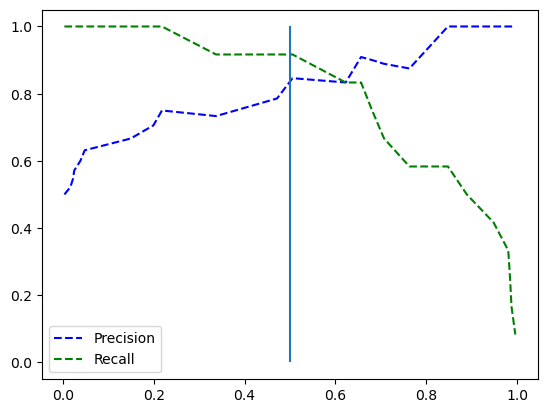

In [15]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(owner_df.Class, owner_df.Probability, pos_label='owner')

def plot_precision_recall_vs_threshold(precisions, recalls, threholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.vlines(x=0.5,ymin=0,ymax=1)
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [16]:
f1_score(owner_df.Class, predicted, pos_label='owner')

0.8799999999999999

## Figure 5.5

In [17]:
fpr, tpr, _ = roc_curve(df.actual, df.prob)
roc_auc = auc(fpr, tpr)

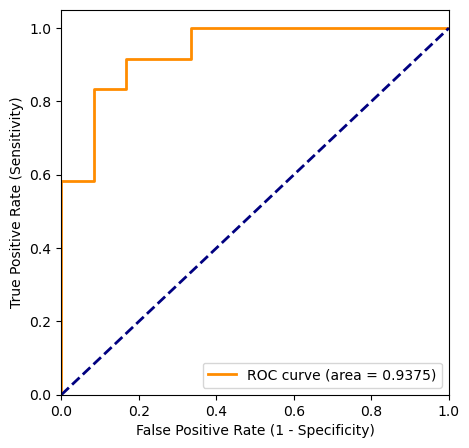

In [18]:
plt.figure(figsize=[5, 5])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()

## Figure 5.6

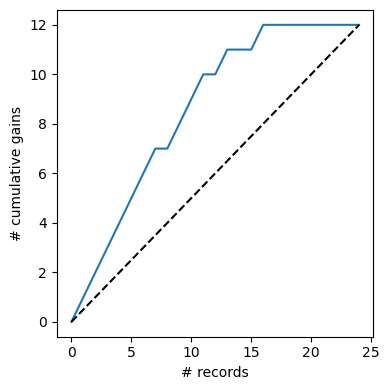

In [19]:
df = pd.read_csv('../data/liftExample.csv')
df = df.sort_values(by=['prob'], ascending=False)

gainsChart(df.actual, figsize=(4, 4))

plt.tight_layout()
plt.show()

## Figure 5.7

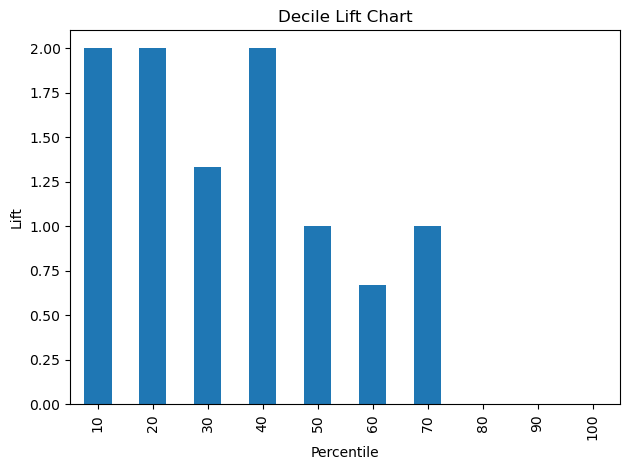

In [20]:
liftChart(df.actual, labelBars=False)
plt.tight_layout()
plt.show()

# 데이터 불균형

Class 0: 3594
Class 1: 644
Proportion: 5.58 : 1


<Axes: title={'center': 'Count (target)'}>

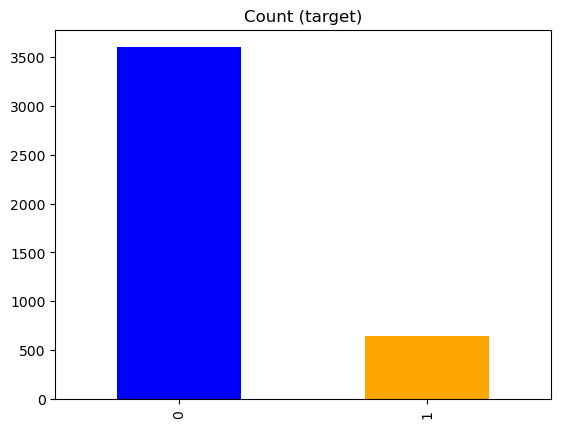

In [22]:
heart = pd.read_csv('../data//framingham_heart_disease.csv')

target_count = heart.TenYearCHD.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)', color=['blue','orange'])

In [43]:
from sklearn.linear_model import LogisticRegression

heart.dropna(inplace=True)
X = heart.drop('TenYearCHD', axis=1)
y = heart['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 85.11%


In [25]:
model2 = LogisticRegression()
model2.fit(X_train[['cigsPerDay']], y_train)
y_pred = model2.predict(X_test[['cigsPerDay']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 84.02%


In [26]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Confusion matrix:
 [[615   0]
 [117   0]]


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

print("Precision: {:.2%}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2%}".format(recall_score(y_test, y_pred)))
print("F1: {:.2%}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.2%}".format(roc_auc_score(y_test, y_pred)))

Precision: 0.00%
Recall: 0.00%
F1: 0.00%
ROC AUC: 50.00%


/Users/fastbat/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Class count
count_class_0, count_class_1 = heart.TenYearCHD.value_counts()
count_class_0, count_class_1

(3099, 557)

In [29]:
# Divide by class
df_class_0 = heart[heart.TenYearCHD == 0]
df_class_1 = heart[heart.TenYearCHD == 1]

Random under-sampling:
0    557
1    557
Name: TenYearCHD, dtype: int64


<Axes: title={'center': 'Count (target)'}>

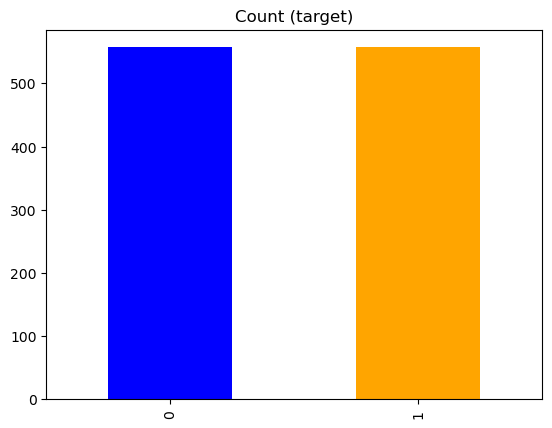

In [30]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_under.TenYearCHD.value_counts())

df_under.TenYearCHD.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])


Random over-sampling:
0    3099
1    3099
Name: TenYearCHD, dtype: int64


<Axes: title={'center': 'Count (target)'}>

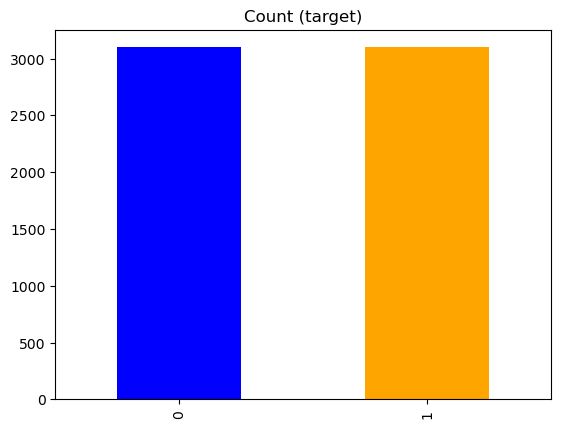

In [31]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.TenYearCHD.value_counts())

df_over.TenYearCHD.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

In [44]:
X = df_under.drop('TenYearCHD', axis=1)
y = df_under['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(accuracy))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Accuracy: 67.26%
Confusion matrix:
 [[73 36]
 [37 77]]


In [45]:
X = df_over.drop('TenYearCHD', axis=1)
y = df_over['TenYearCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(accuracy))

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Accuracy: 68.87%
Confusion matrix:
 [[429 175]
 [211 425]]


# imbalanced-learn

In [34]:
!pip install imblearn

<Axes: title={'center': 'Count (target)'}>

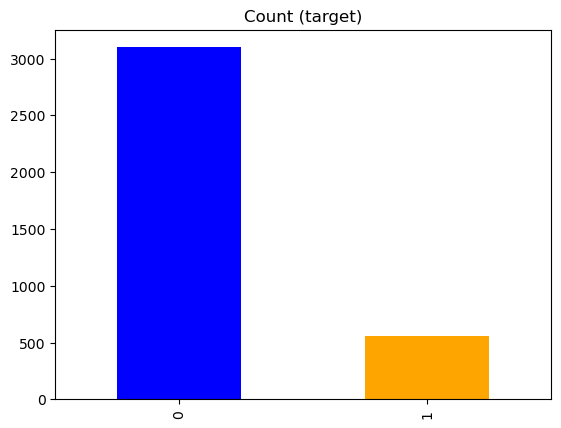

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

heart = pd.read_csv('../data/framingham_heart_disease.csv')
heart = heart.dropna()
X = heart.drop('TenYearCHD', axis=1)
y = heart['TenYearCHD']

y.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

<Axes: title={'center': 'Count (target)'}>

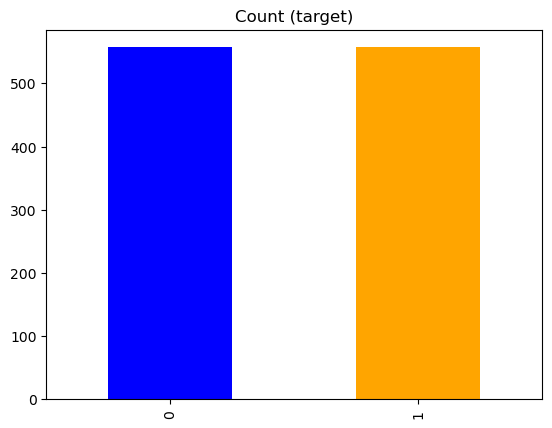

In [37]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

y_rus.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

2542 new random picked points


<Axes: title={'center': 'Count (target)'}>

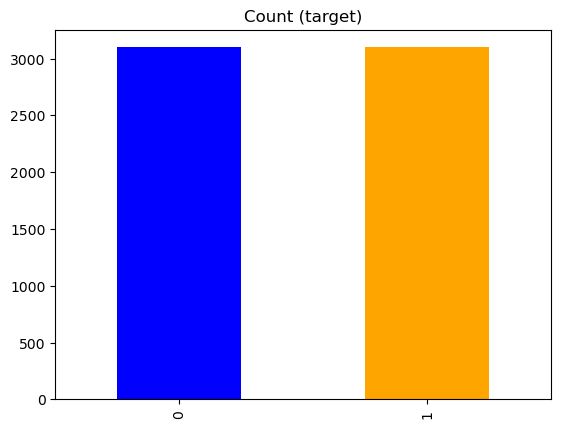

In [38]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

y_ros.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

## 언더, 오버 샘플링 데이터 활용하기

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

heart = pd.read_csv('../data/framingham_heart_disease.csv')
heart = heart.dropna()
X = heart.drop('TenYearCHD', axis=1)
y = heart['TenYearCHD']

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with under sampling: {:.2%}".format(accuracy))

Accuracy with under sampling: 71.30%


In [47]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Confusion matrix:
 [[82 34]
 [30 77]]


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with over sampling: {:.2%}".format(accuracy))

Accuracy with over sampling: 69.11%


In [49]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Confusion matrix:
 [[421 212]
 [171 436]]


- 언더 샘플링: Tomek links

<Axes: title={'center': 'Count (target)'}>

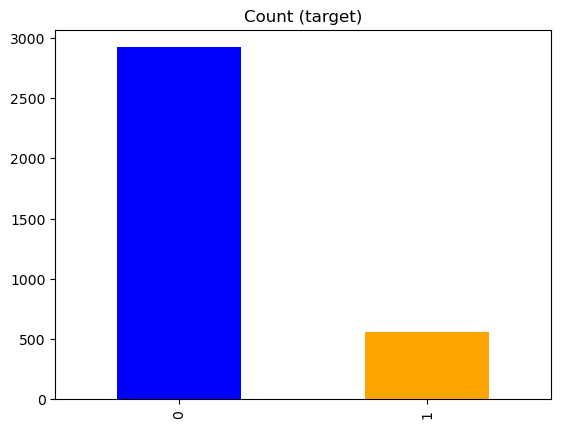

In [52]:
from imblearn.under_sampling import TomekLinks

X = heart.drop('TenYearCHD', axis=1)
y = heart['TenYearCHD']
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y)

y_tl.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

- 언더 샘플링: 군집화 중앙값 (Kmeans 군집화)

/Users/fastbat/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: title={'center': 'Count (target)'}>

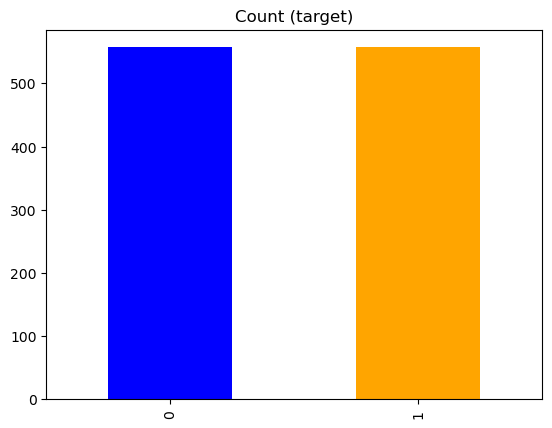

In [53]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X, y)

y_cc.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

- 오버 샘플링: SMOTE

<Axes: title={'center': 'Count (target)'}>

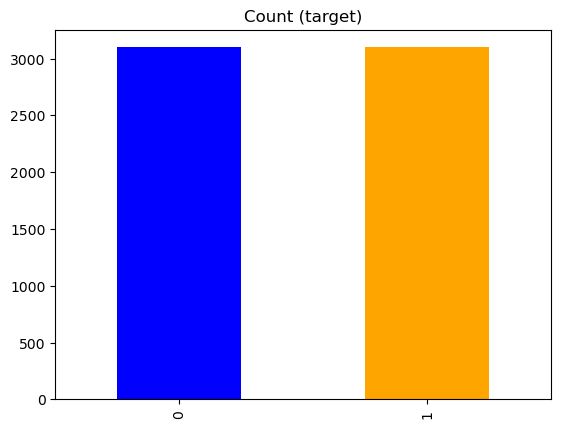

In [55]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts().plot(kind='bar', title='Count (target)', color=['blue','orange'])

## 성과 측정

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.2)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("ROC AUC with Tomek links: {:.2%}".format(roc_auc_score(y_test, y_pred)))

ROC AUC with Tomek links: 53.31%


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_cc, y_cc, test_size=0.2)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("ROC AUC with under sampling by clustering centroids: {:.2%}".format(roc_auc_score(y_test, y_pred)))

ROC AUC with under sampling by clustering centroids: 75.34%


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("ROC AUC with over sampling by SMOTE: {:.2%}".format(roc_auc_score(y_test, y_pred)))

ROC AUC with over sampling by SMOTE: 69.67%
